In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/My Drive/Flipkart_Grid_Woz

/content/drive/My Drive/Flipkart_Grid_Woz


In [11]:
!unzip spectrograms.zip

Streaming output truncated to the last 5000 lines.
  inflating: spectrogram_audio/1002.npy  
  inflating: spectrogram_audio/1003.npy  
  inflating: spectrogram_audio/1004.npy  
  inflating: spectrogram_audio/1005.npy  
  inflating: spectrogram_audio/1006.npy  
  inflating: spectrogram_audio/1007.npy  
  inflating: spectrogram_audio/1008.npy  
  inflating: spectrogram_audio/1009.npy  
  inflating: spectrogram_audio/101.npy  
  inflating: spectrogram_audio/1010.npy  
  inflating: spectrogram_audio/1011.npy  
  inflating: spectrogram_audio/1012.npy  
  inflating: spectrogram_audio/1013.npy  
  inflating: spectrogram_audio/1014.npy  
  inflating: spectrogram_audio/1015.npy  
  inflating: spectrogram_audio/1016.npy  
  inflating: spectrogram_audio/1017.npy  
  inflating: spectrogram_audio/1018.npy  
  inflating: spectrogram_audio/1019.npy  
  inflating: spectrogram_audio/102.npy  
  inflating: spectrogram_audio/1020.npy  
  inflating: spectrogram_audio/1021.npy  
  inflating: spectrogram_au

In [12]:
import os
import numpy as np
np_combined = np.array(os.listdir("spectrogram_audio"))
np_speech = np.array(os.listdir("spectrogram_speech"))

In [13]:
Train_x = []
Train_y = []
j = 0
for s in np_combined:
    Train_x.append((np.load("spectrogram_audio/"+s)))
    Train_y.append((np.load("spectrogram_speech/"+s)))
    print(j)
    j += 1

Streaming output truncated to the last 5000 lines.
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267

In [14]:
np.shape(Train_x)

(5005, 256, 256)

In [15]:
train_x = np.array(Train_x).reshape([len(Train_x),256,256,1])/80
train_y = np.array(Train_y).reshape([len(Train_y),256,256,1])/80

In [16]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import keras
from matplotlib import pyplot
 
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


Using TensorFlow backend.


In [17]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g
 
def define_generator(image_shape=(256,256,1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    return model
 
def define_gan(g_model, d_model, image_shape):
    d_model.trainable = False
    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model
 


In [20]:
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
    ix = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y
 

def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

max_g_loss,min_g_loss = 0, 1000 
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs  
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        if(i%1000!=0):
          max_g_loss = max(g_loss,max_g_loss)
          min_g_loss = min(g_loss,min_g_loss)
        else:
          max_g_loss,min_g_loss = g_loss,g_loss  
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f] gmax[%.3f] gmin[%.3f]' % (i+1, d_loss1, d_loss2, g_loss,max_g_loss,min_g_loss))

dataset = [train_x, train_y]
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)
train(d_model, g_model, gan_model, dataset,n_epochs = 5)

Loaded (5005, 256, 256, 1) (5005, 256, 256, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>20027, d1[0.001] d2[0.095] g[13.622] gmax[18.121] gmin[6.241]
>20028, d1[0.081] d2[0.028] g[15.219] gmax[18.121] gmin[6.241]
>20029, d1[0.676] d2[0.355] g[7.245] gmax[18.121] gmin[6.241]
>20030, d1[0.033] d2[0.219] g[9.037] gmax[18.121] gmin[6.241]
>20031, d1[0.101] d2[0.267] g[8.527] gmax[18.121] gmin[6.241]
>20032, d1[0.530] d2[0.081] g[12.511] gmax[18.121] gmin[6.241]
>20033, d1[0.470] d2[0.458] g[11.316] gmax[18.121] gmin[6.241]
>20034, d1[0.141] d2[0.185] g[8.546] gmax[18.121] gmin[6.241]
>20035, d1[0.038] d2[0.267] g[13.195] gmax[18.121] gmin[6.241]
>20036, d1[0.088] d2[0.168] g[11.621] gmax[18.121] gmin[6.241]
>20037, d1[0.274] d2[0.235] g[10.313] gmax[18.121] gmin[6.241]
>20038, d1[0.140] d2[0.077] g[7.886] gmax[18.121] gmin[6.241]
>20039, d1[0.062] d2[0.181] g[10.934] gmax[18.121] gmin[6.241]
>20040, d1[0.001] d2[0.038] g[6.791] gmax[18.121] gmin[6.241]
>20041, d1[0.068] d2[0.015] g[8.146] gmax[18.121] gmin[6.241]
>20042, d1[

In [21]:
d_model.save('d_model.h5')
g_model.save('g_model.h5')

In [22]:
import librosa

In [64]:
audio,sr = librosa.load("combined_street/Test_2.ogg",16000)
n_fft = 511
hop_length_fft = 63
frame_length = 8064*2
chunk_mag = []
chunk_pha = []
i = 0
while (i+frame_length<len(audio)):
    stftaudio = librosa.stft(audio[i:i+frame_length], n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)
    chunk_mag.append(stftaudio_magnitude_db/80)
    chunk_pha.append(stftaudio_phase)
    i += frame_length



In [65]:
test_x = np.array(chunk_mag).reshape([len(chunk_mag),256,256,1])

In [66]:
pred_y = g_model.predict(test_x)

In [67]:
np.shape(pred_y)

(3, 256, 256, 1)

In [68]:
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

In [69]:
def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

In [70]:
audio_denoise_recons = matrix_spectrogram_to_numpy_audio(pred_y[:,:,:,0]*80, np.array(chunk_pha), frame_length, hop_length_fft)
nb_samples = audio_denoise_recons.shape[0]
denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10

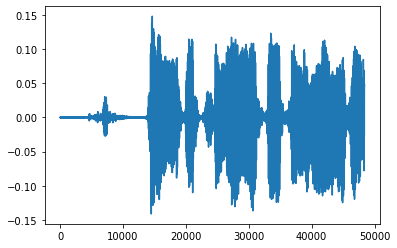

In [71]:
import matplotlib.pyplot as plt
plt.plot(denoise_long[0, :])

In [72]:
audio,sr = librosa.load("combined_street/Test_2.ogg",16000)
librosa.output.write_wav('noisy.wav', audio, sr)

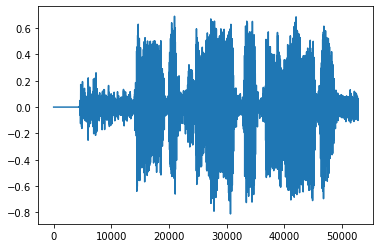

In [73]:
plt.plot(audio)

In [74]:
import IPython.display as ipd
ipd.Audio(data = denoise_long[0, :], rate = sr )

In [75]:
import IPython.display as ipd
ipd.Audio(data = audio, rate = sr )

In [ ]:
audio,sr = librosa.load("combined_street/56.wav")

In [ ]:
len(audio)

In [ ]:
audio,sr = librosa.load("combined_street/6.wav", sr = 8000)

In [ ]:
len(audio)